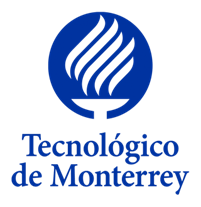

## Computer Vision (Gpo 10)

### Professors: 
* Dr. Gilberto Ochoa Ruiz
* Mtra. Yetnalezi Quintas Ruiz

### Students: 
* Armando Bringas Corpus - A01200230
* Guillermo Alfonso Muñiz Hermosillo - A01793101
* Jorge Luis Arroyo Chavelas - A01793023
* Samantha R Mancias Carrillo - A01196762
* Sofia E Mancias Carrillo - A01196563




# Image Segmentation - Watershed

## Table of Contents
1. [Libraries](#libraries)
2. [Implementation with OpenCV](#opencv)

    a. [Marker-based image segmentation](#opencv_markerbased)

2. [Implementation with skimage](#skimage)
    
    a. [Compact Watershed](#skimage_compactwatershed)
    
    b. [Morphological Watershed Algorithm](#skimage_morphologicalwatershed)

3. [Applications](#applications)

    a. [Cell Nuclei Analysis](#cellnucleianalysis)

## Libraries <a class="anchor" id="libraries" ></a>

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage.color import rgb2gray
from skimage.filters import sobel
from skimage.segmentation import mark_boundaries,watershed
from skimage.io import imread

## Implementation with Open CV <a class="anchor" id="opencv" ></a>

### Marker-based image segmentation <a class="anchor" id="opencv_markerbased" ></a>

In [2]:
def plot_images(img1, img2, img1_title, img2_title):
    plt.figure(figsize=([20, 20]))
    plt.subplot(121),plt.imshow(img1, cmap='gray')
    plt.title(img1_title, size=15), plt.xticks([]), plt.yticks([])
    plt.subplot(122),plt.imshow(img2, cmap='gray')
    plt.title(img2_title, size=15), plt.xticks([]), plt.yticks([])
    plt.show()

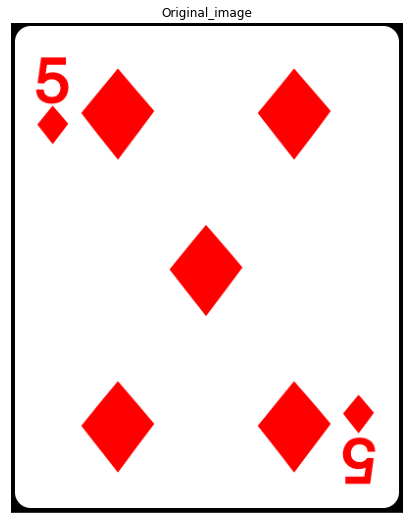

In [3]:
# Load image 
img = cv2.imread('img/card.png')
img_RGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=([9, 9]))
plt.imshow(img_RGB), plt.title('Original_image'), plt.xticks([]), plt.yticks([])
plt.show()

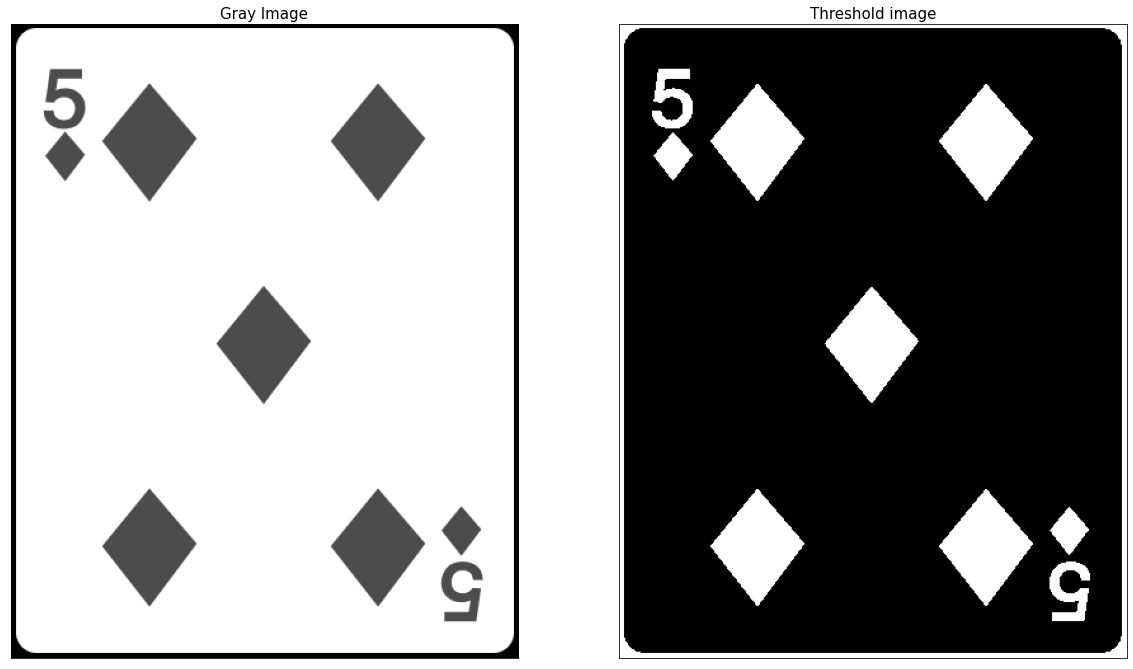

In [4]:
# convert from color to grayscale
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Divide the image into two regions, blacks and whites
ret, thresh = cv2.threshold(gray_img, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

plot_images(gray_img, thresh, 'Gray Image', 'Threshold image')


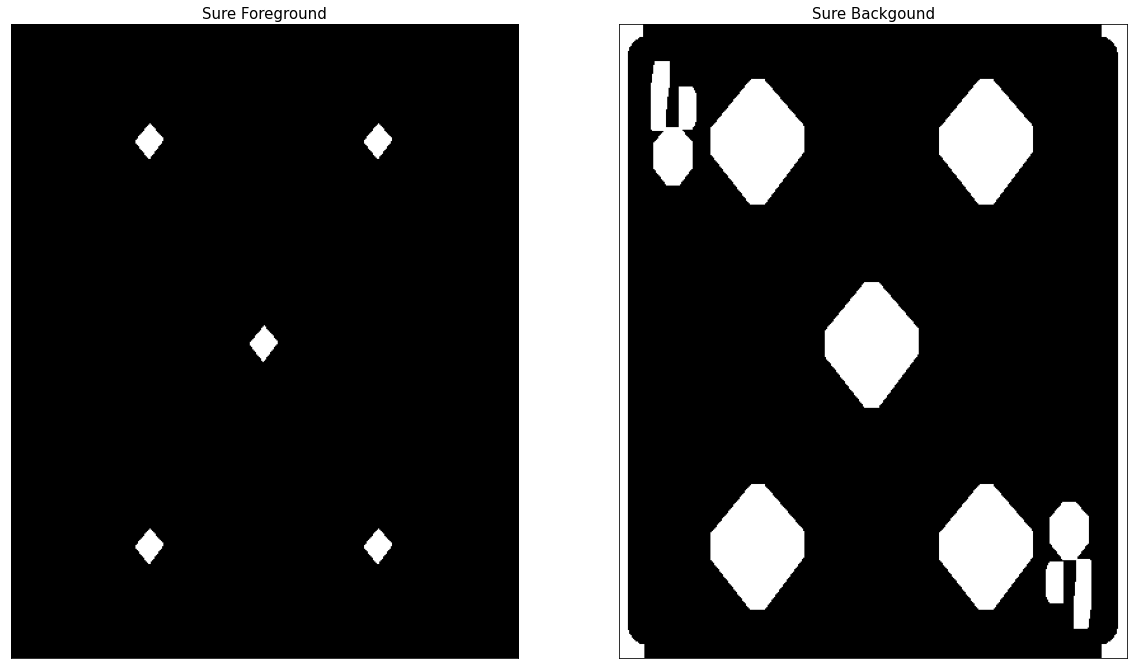

In [5]:
# noise removal
kernel = np.ones((5,3),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)
# sure background area
sure_bg = cv2.dilate(opening,kernel,iterations=3)
# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)
# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)

# Plot the results
plot_images(sure_fg, sure_bg, 'Sure Foreground', 'Sure Backgound')

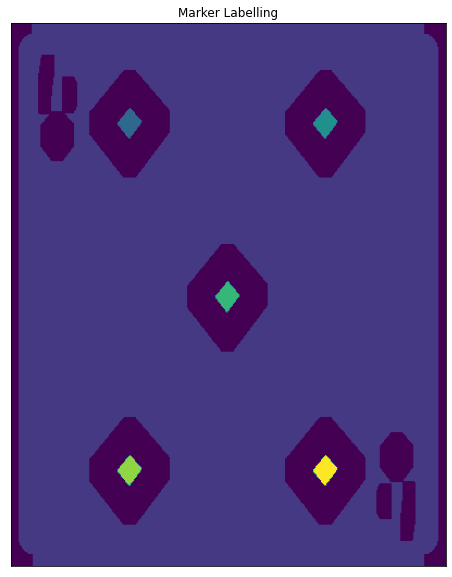

In [6]:
# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)

# Add one to all labels so that sure background is not 0, but 1
markers = markers+1

# Now, mark the region of unknown with zero
markers[unknown==255] = 0

plt.figure(figsize=([10, 10]))
plt.imshow(markers), plt.title('Marker Labelling'), plt.xticks([]), plt.yticks([])
plt.show()


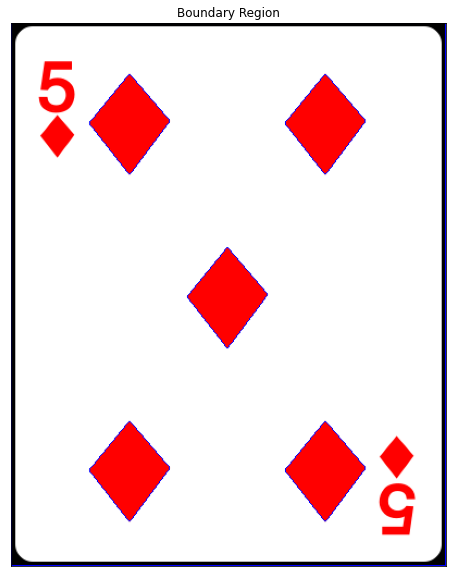

In [7]:
# Apply watershed, boundary region will be marked with -1
markers = cv2.watershed(img,markers)
img[markers == -1] = [255,0,0]

plt.figure(figsize=([10, 10]))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)), plt.title('Boundary Region'), plt.xticks([]), plt.yticks([])
plt.show()

## Implementation with skimage <a class="anchor" id="skimage" ></a>

### Compact Watershed <a class="anchor" id="skimage_compactwatershed" ></a>

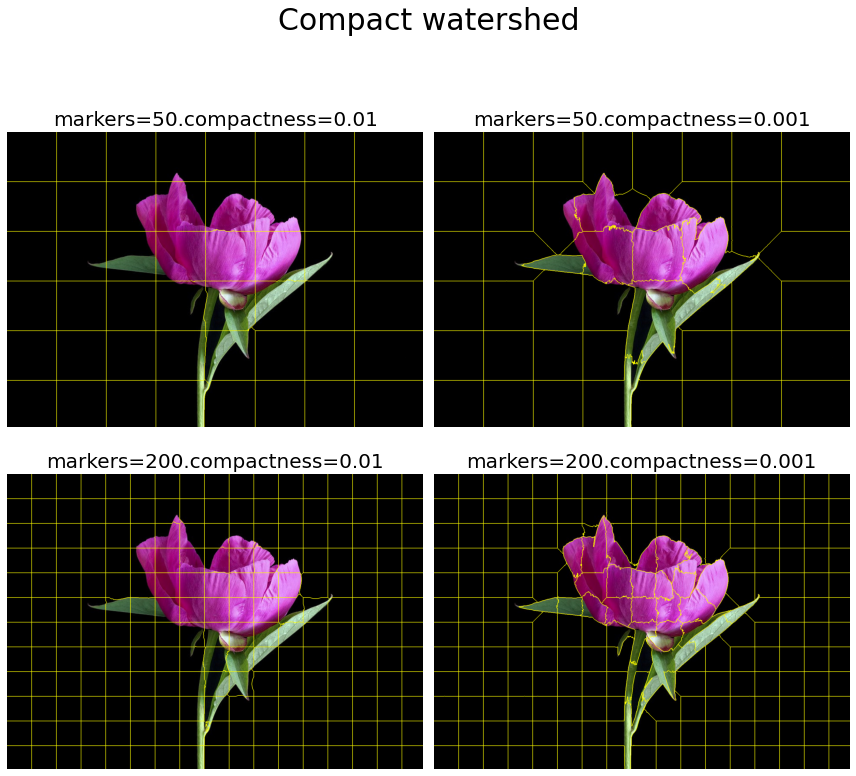

In [8]:
# Load image and select every other pixel in each dimension
img = imread('img/Peony-Rose-Flowers.jpg')[::2, ::2, :3]

# Compute gradient of image
gradient = sobel(rgb2gray(img))

# Set up plot
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
axs = axs.ravel()

# Setup parameters for Watershed algorithm
markers_list = [50, 50, 200, 200]
compactness_list = [0.01, 0.001, 0.01, 0.001]

# Apply watershed segmentation with different parameters and plot results
for i, (markers, compactness) in enumerate(zip(markers_list, compactness_list)):
    segments_watershed = watershed(gradient, markers=markers, compactness=compactness)
    axs[i].imshow(mark_boundaries(img, segments_watershed))
    axs[i].set_title(f"markers={markers}.compactness={compactness}", size=20)
    axs[i].axis('off')

plt.suptitle('Compact watershed', size=30)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### Morphological Watershed Algorithm <a class="anchor" id="skimage_morphologicalwatershed" ></a>

## Implementation with Simpleitk <a class="anchor" id="simpleitk" ></a>

In [57]:
%matplotlib inline
import matplotlib.pyplot as plt
import SimpleITK as sitk
from myshow import myshow, myshow3d


# Download data to work on]
%run update_path_to_download_script
from downloaddata import fetch_data as fdata

from ipywidgets import interact, interactive, FloatSlider


<Figure size 432x288 with 0 Axes>

In [63]:
def watershed_otsu_labeling(img,spot_sigma=2, outline_sigma=2, watershed_level=10, show_watershed_edge=True):
    blurred_spots = sitk.GradientMagnitudeRecursiveGaussian(img, sigma=spot_sigma)
    blurred_outline = sitk.DiscreteGaussian(img, variance=[outline_sigma, outline_sigma, outline_sigma])
    binary_otsu = sitk.OtsuThreshold(blurred_outline, 0, 1)
    ws = sitk.MorphologicalWatershed(blurred_spots, markWatershedLine=show_watershed_edge, level=watershed_level)
    labels = sitk.Mask(ws, sitk.Cast(binary_otsu, ws.GetPixelID()))
    # myshow(labels, title='Watershed Otsu labeling')
    
    myshow(sitk.LabelToRGB(labels), title="Watershed Segmentation")

Fetching cthead1.png


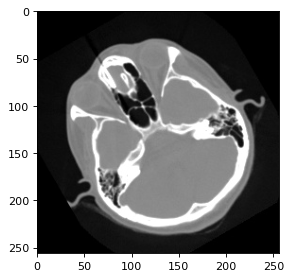

In [64]:
img = sitk.ReadImage(fdata("cthead1.png"))
myshow(img)

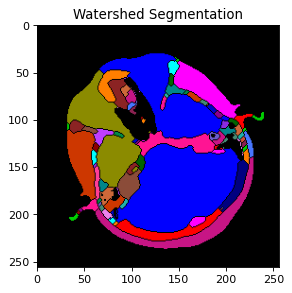

In [67]:
watershed_otsu_labeling(img,spot_sigma=2, outline_sigma=2, watershed_level=5, show_watershed_edge=True)

In [65]:
def callback(img, *args, **kwargs):
    watershed_otsu_labeling(img, *args, **kwargs)
    
interact(
    lambda **kwargs: callback(img, **kwargs),
    spot_sigma = FloatSlider(min=.1, max=5, step=.1, value=2),
    outline_sigma = FloatSlider(min=.1, max=5, step=.1, value=2),
    watershed_level = FloatSlider(min=1, max=10, step=.1, value=5),
    show_watershed_edge = True
)

interactive(children=(FloatSlider(value=2.0, description='spot_sigma', max=5.0, min=0.1), FloatSlider(value=2.…

<function __main__.<lambda>(**kwargs)>

## Applications <a class="anchor" id="applications" ></a>

In [15]:
# Reimport of Libraries to avoid conflics with previous examples

import cv2
import numpy as np


### Cell Nuclei Analysis